<a href="https://colab.research.google.com/github/glennamaria/Projects/blob/main/fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path="/content/drive/MyDrive/Project.csv"
df= pd.read_csv(path)
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,C1179511630,479803.00,347245.65,C435674507,484329.37,616886.72,0,0
1048571,95,PAYMENT,9917.36,C1956161225,90545.00,80627.64,M668364942,0.00,0.00,0,0
1048572,95,PAYMENT,14140.05,C2037964975,20545.00,6404.95,M1355182933,0.00,0.00,0,0
1048573,95,PAYMENT,10020.05,C1633237354,90605.00,80584.95,M1964992463,0.00,0.00,0,0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display first few rows
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


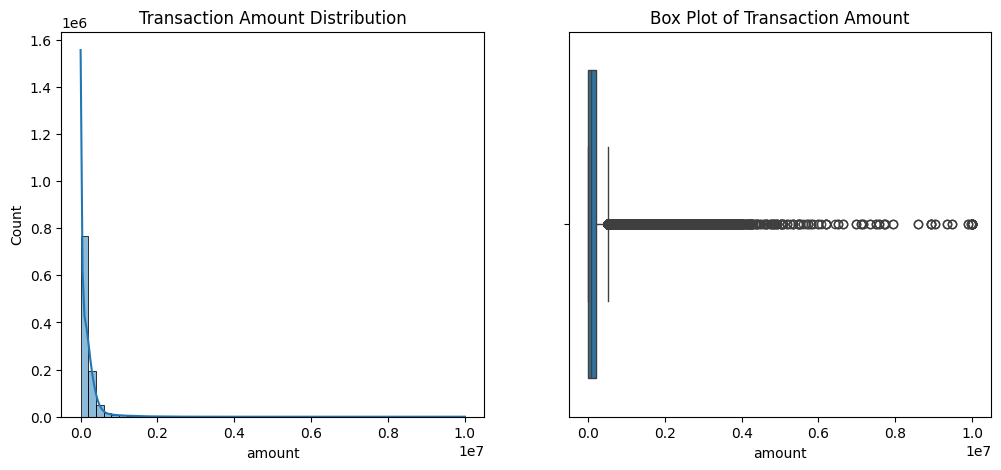

In [5]:
plt.figure(figsize=(12,5))

# Histogram
plt.subplot(1,2,1)
sns.histplot(df['amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")

# Box Plot
plt.subplot(1,2,2)
sns.boxplot(x=df['amount'])
plt.title("Box Plot of Transaction Amount")

plt.show()


<ipython-input-6-76ad21308355>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='isFraud', data=df, palette=['blue', 'red'])


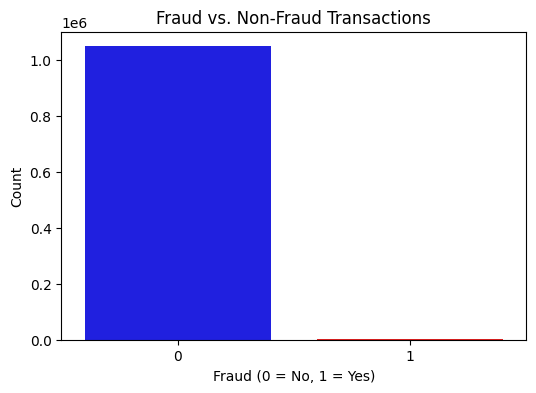

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df, palette=['blue', 'red'])
plt.title("Fraud vs. Non-Fraud Transactions")
plt.xlabel("Fraud (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


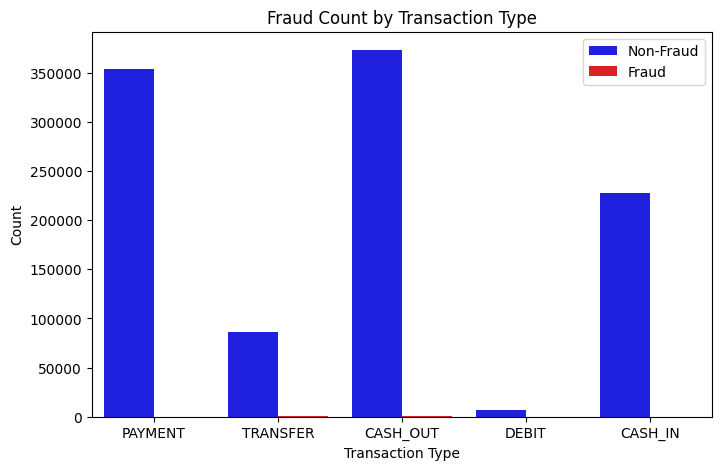

In [7]:
plt.figure(figsize=(8,5))
sns.countplot(x='type', hue='isFraud', data=df, palette=['blue', 'red'])
plt.title("Fraud Count by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.legend(["Non-Fraud", "Fraud"])
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


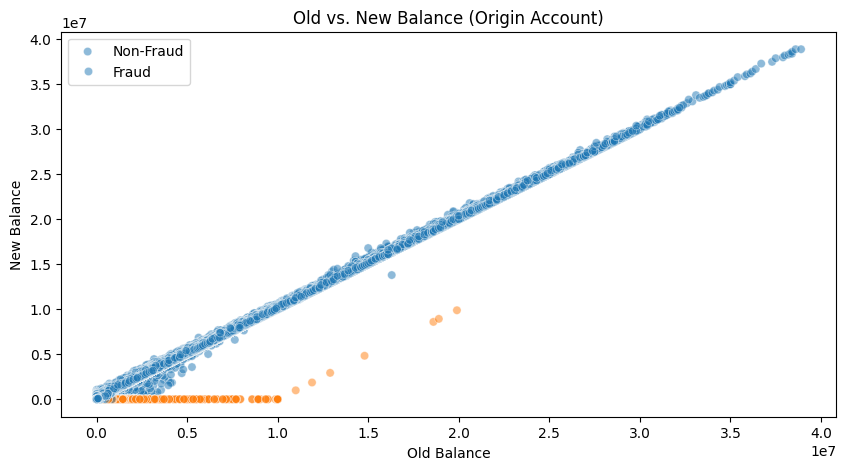

In [8]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=df['oldbalanceOrg'], y=df['newbalanceOrig'], hue=df['isFraud'], alpha=0.5)
plt.title("Old vs. New Balance (Origin Account)")
plt.xlabel("Old Balance")
plt.ylabel("New Balance")
plt.legend(["Non-Fraud", "Fraud"])
plt.show()


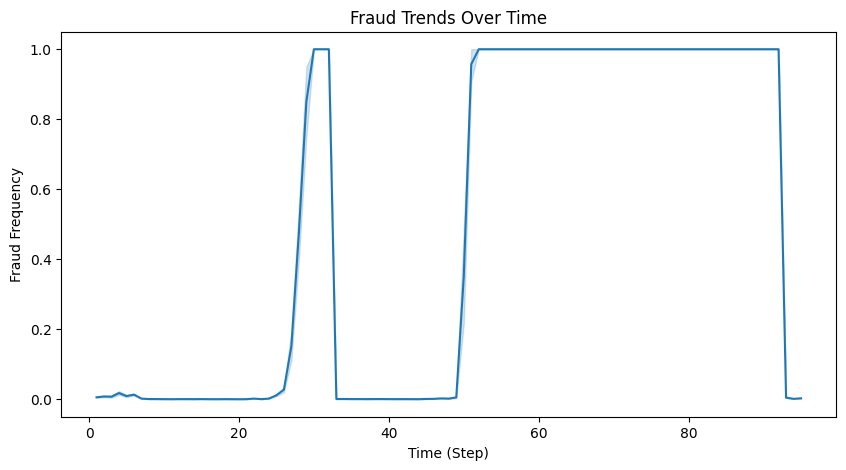

In [11]:
plt.figure(figsize=(10,5))
sns.lineplot(x=df['step'], y=df['isFraud'].rolling(window=10).mean())
plt.title("Fraud Trends Over Time")
plt.xlabel("Time (Step)")
plt.ylabel("Fraud Frequency")
plt.show()



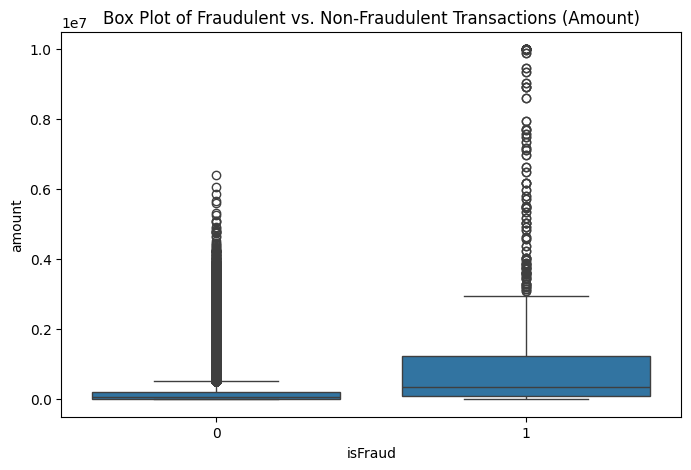

In [12]:
plt.figure(figsize=(8,5))
sns.boxplot(x='isFraud', y='amount', data=df)
plt.title("Box Plot of Fraudulent vs. Non-Fraudulent Transactions (Amount)")
plt.show()
